## Esperienza 2: Global Warming

### Imports:

In [1]:
import ultranest
import read_data as rd
import george 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from ultranest.plot import cornerplot

### Reading the data

In [2]:
# Read the data from the file
file_path = 'Land_and_Ocean_summary.txt' 
df = rd.read_land_ocean_data(file_path)
df = df[['Year', 'Annual_Anomaly', 'Annual_Unc']]

# Rename columns
df.columns = ["Year", "Annual_Anomaly", "Annual_Anomaly_Error"]

# Save the data in arrays
year = np.array( df["Year"])
temp = np.array( df["Annual_Anomaly"])
temp_err = np.array( df["Annual_Anomaly_Error"])

df

,Year,Annual_Anomaly,Annual_Anomaly_Error
0,1851,-0.321,0.259
1,1852,-0.292,0.249
2,1853,-0.295,0.196
3,1854,-0.283,0.130
4,1855,-0.278,0.120
...,...,...,...
169,2020,1.049,0.032
170,2021,0.895,0.030
171,2022,0.936,0.031
172,2023,1.229,0.031


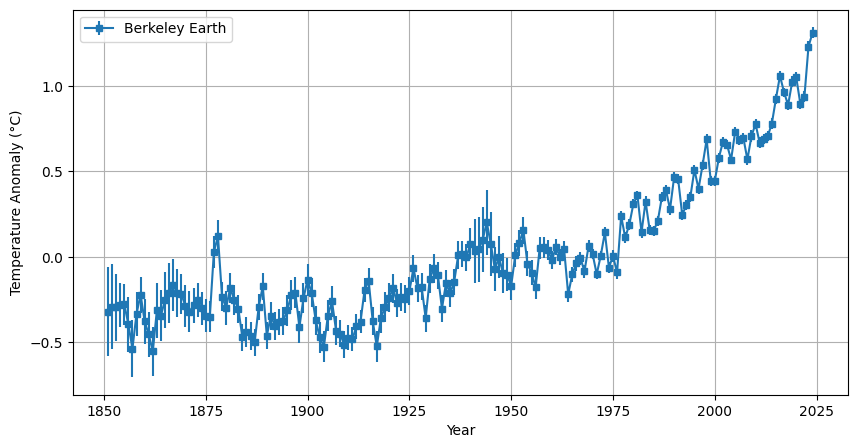

In [ ]:
# Let's face the data
plt.figure(figsize=(10, 5))
plt.errorbar( df['Year'], df['Annual_Anomaly'], df['Annual_Anomaly_Error'], label='Berkeley Earth', fmt='s',  markersize= 5, linestyle= "-")
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

### Models
*   Constant Temperature (const)        $T(y) = K$
*   Linear Temperature (lin)            $T(y) = a y + b$
*   Exponential Temperature (exp)       $T(y) = c e^{d y}$
*   2nd Exponential Temperature (exp2)  $T(y) = e \; e^{f y} + g$

#### Definitions:

In [28]:
#====================================================================================
# Constants
const_params = ['k']            #constant temperature
lin_params = ['a', 'b']         #linear temperature
exp_params = ['c', 'd']         #exponential temperature
exp2_params = ['e', 'f', 'g']    #exponential temperature 2



#====================================================================================
# Log_likelihoods

#constant 
def const_loglikelihood(params):
    (k) = params
    log_like = -np.sum(((temp - k)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like

#linear
def lin_loglikelihood(params):
    (a, b) = params
    pred = a*(year - 1937) + b
    log_like = -np.sum(((temp - pred)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like

#exponential
def exp_loglikelihood(params):
    (c, d) = params
    pred = c * np.exp(d * (year - 1937)) 
    log_like = -np.sum(((temp - pred)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like

#exponential 2
def exp2_loglikelihood(params):
    (e, f, g) = params
    pred = e * np.exp(f * (year - 1937)) + g
    log_like = -np.sum(((temp - pred)/temp_err)**2 + np.log(2*np.pi*temp_err**2)) / 2 
    return log_like


#====================================================================================
# Flat priors

#constant
def const_prior(u):
    params = u.copy()
    hi = 2
    lo = -2
    params[0] = lo + (hi-lo)*u[0]
    return params

#linear
def lin_prior(u):
    params = u.copy()
    hi = [0.05, 2]
    lo = [-0.05, -2]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

#exponential
def exp_prior(u):
    params = u.copy()
    hi = [1, 0.5]
    lo = [-1, 0.]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

#exponential 2
def exp2_prior(u):
    params = u.copy()
    hi = [1, 0.5, 1]
    lo = [-1, 0., -1]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

In [29]:
const_sampler = ultranest.ReactiveNestedSampler(const_params, const_loglikelihood, const_prior)
lin_sampler = ultranest.ReactiveNestedSampler(lin_params, lin_loglikelihood, lin_prior)
exp_sampler = ultranest.ReactiveNestedSampler(exp_params, exp_loglikelihood, exp_prior)
exp2_sampler = ultranest.ReactiveNestedSampler(exp2_params, exp2_loglikelihood, exp2_prior)

#### Constant Temperature
$$
T(y) = K \; ,
$$
where $T$ is the temperature anomaly and $y$ is the year.

In [30]:
print('\nInference with constant temperature model:\n')
const_result = const_sampler.run(min_num_live_points=1000, viz_callback=None)

print('\nConstant temperature model:')
const_sampler.print_results()

cornerplot(const_result)


Inference with constant temperature model:

[ultranest] Sampling 1000 live points from prior ...


KeyboardInterrupt: 

#### Linear Temperature
$$
T(y) = a y + b \; .
$$

In [ ]:
print('\nInference with linear temperature model:\n')
lin_result = lin_sampler.run(min_num_live_points=1000, viz_callback=None)

print('\nLinear temperature model:')
lin_sampler.print_results()

cornerplot(lin_result)


Inference with linear temperature model:

[ultranest] Sampling 1000 live points from prior ...
[ultranest] Explored until L=-1e+03  404.61 [-1404.6172..-1404.6171]*| it/evals=16759/21607 eff=81.3267% N=1000    0 
[ultranest] Likelihood function evaluations: 21618
[ultranest]   logZ = -1417 +- 0.08868
[ultranest] Effective samples strategy satisfied (ESS = 4060.9, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.11 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.



#### Exponential Temperature 
$$
T(y) = c e^{d y} \; ,
$$

In [ ]:
print('\nInference with exponential temperature model:\n')
exp_result = exp_sampler.run(min_num_live_points=1000, viz_callback=None)


print('\nExponential temperature model:')
exp_sampler.print_results()

cornerplot(exp_result)


Inference with exponential temperature model:

[ultranest] Sampling 1000 live points from prior ...
[ultranest] Explored until L=-8e+02  .59 [-771.6037..-771.6037]*| it/evals=19040/37790 eff=51.7532% N=1000   0   0  
[ultranest] Likelihood function evaluations: 37793
[ultranest]   logZ = -786 +- 0.09042
[ultranest] Effective samples strategy satisfied (ESS = 4106.6, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.46+-0.05 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.


#### Exponential Temperature 2
$$
T(y) = e \; e^{f y} + g\; .
$$

In [ ]:
print('\nInference with exponential 2 temperature model:\n')
exp2_result = exp2_sampler.run(min_num_live_points=1000, viz_callback=None)

print('\nExponential 2 temperature model:')
exp2_sampler.print_results()

cornerplot(exp2_result);


Inference with exponential 2 temperature model:

[ultranest] Sampling 1000 live points from prior ...
[ultranest] Explored until L=-1e+02  .11 [-136.1683..-136.1681]*| it/evals=22012/101258 eff=21.9554% N=1000   0  0  
[ultranest] Likelihood function evaluations: 101277
[ultranest]   logZ = -153.6 +- 0.09359
[ultranest] Effective samples strategy satisfied (ESS = 4735.0, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.04 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.13 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.


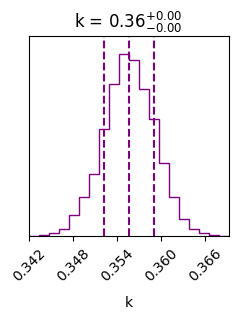

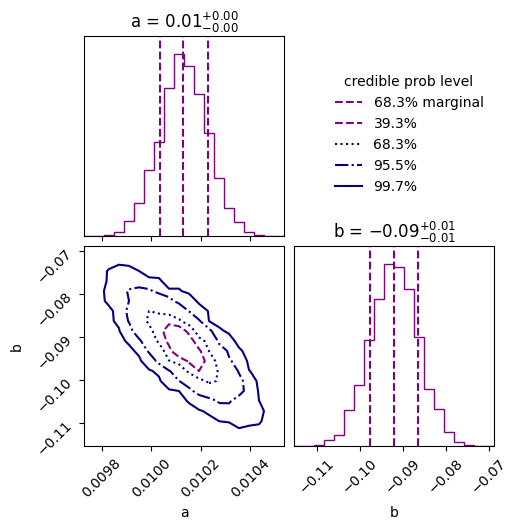

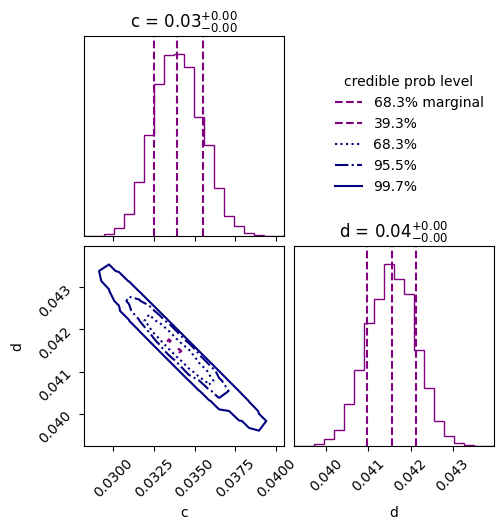

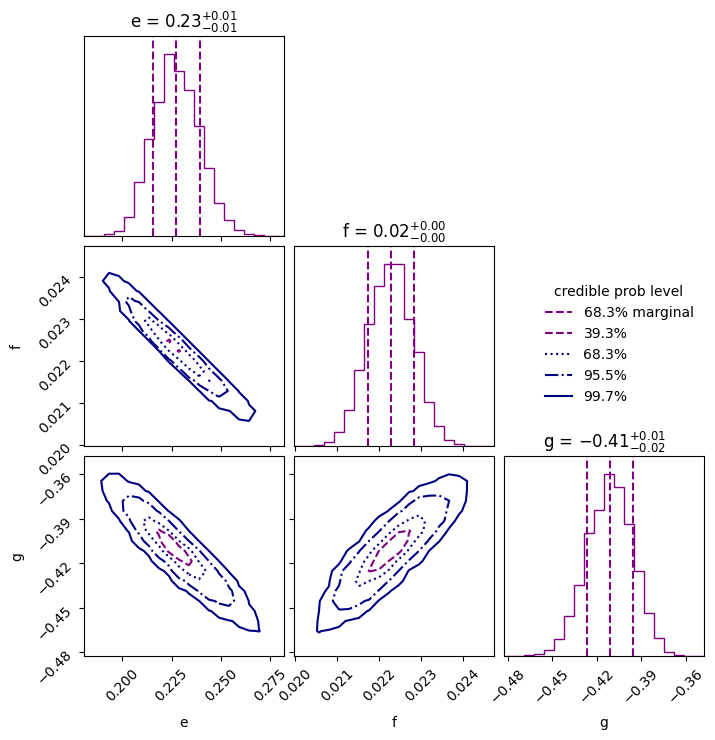

### Inferred parameters:

In [12]:
#inferred parameters

#constant temperature
const_samples = const_result["samples"][:, 0] 
k_best = np.median(const_samples)
k_lower_95, k_upper_95 = np.percentile(const_samples, [2.5, 97.5])


#linear temperature
a_lin_samples = lin_result["samples"][:, 0] 
a_best = np.median(a_lin_samples)
a_lower_95, a_upper_95 = np.percentile(a_lin_samples, [2.5, 9.5])

b_lin_samples = lin_result["samples"][:, 1] 
b_best = np.median(b_lin_samples)
b_lower_95, b_upper_95 = np.percentile(b_lin_samples, [2.5, 97.5])

#exponential temperature
c_exp_samples = exp_result["samples"][:, 0] 
c_best = np.median(c_exp_samples)
c_lower_95, c_upper_95 = np.percentile(c_exp_samples, [2.5, 97.5])

d_exp_samples = exp_result["samples"][:, 1] 
d_best = np.median(d_exp_samples)
d_lower_95, d_upper_95 = np.percentile(d_exp_samples, [2.5, 97.5])

#exponential temperature 2
e_exp2_samples = exp2_result["samples"][:, 0] 
e_best = np.median(e_exp2_samples)
e_lower_95, e_upper_95 = np.percentile(e_exp2_samples, [2.5, 97.5])

f_exp2_samples = exp2_result["samples"][:, 1] 
f_best = np.median(f_exp2_samples)
f_lower_95, f_upper_95 = np.percentile(f_exp2_samples, [2.5, 97.5])

g_exp2_samples = exp2_result["samples"][:, 2] 
g_best = np.median(g_exp2_samples)
g_lower_95, g_upper_95 = np.percentile(g_exp2_samples, [2.5, 97.5])


# Print the results
print(f"Constant Model of Temperature:\nBest estimate of k: {k_best:.3f}")
print(f"95% Credible Interval: [{k_lower_95:.3f}, {k_upper_95:.3f}]\n")

print(f"Linear Model of Temperature:\nBest estimate of a: {a_best:.3f}")
print(f"95% Credible Interval: [{a_lower_95:.3f}, {a_upper_95:.3f}]")
print(f"Best estimate of b: {b_best:.3f}")
print(f"95% Credible Interval: [{b_lower_95:.3f}, {b_upper_95:.3f}]\n")

print(f"Exponential Model of Temperature:\nBest estimate of c: {c_best:.3f}")
print(f"95% Credible Interval: [{c_lower_95:.3f}, {c_upper_95:.3f}]")
print(f"Best estimate of d: {d_best:.3f}")
print(f"95% Credible Interval: [{d_lower_95:.3f}, {d_upper_95:.3f}]\n")

print(f"Exponential Model of Temperature 2:\nBest estimate of e: {e_best:.3f}")
print(f"95% Credible Interval: [{e_lower_95:.3f}, {e_upper_95:.3f}]")
print(f"Best estimate of f: {f_best:.3f}")
print(f"95% Credible Interval: [{f_lower_95:.3f}, {f_upper_95:.3f}]\n")
print(f"Best estimate of g: {g_best:.3f}")
print(f"95% Credible Interval: [{g_lower_95:.3f}, {g_upper_95:.3f}]\n")

Constant Model of Temperature:
Best estimate of k: 0.356
95% Credible Interval: [0.349, 0.362]

Linear Model of Temperature:
Best estimate of a: 0.010
95% Credible Interval: [0.010, 0.010]
Best estimate of b: -0.092
95% Credible Interval: [-0.103, -0.081]

Exponential Model of Temperature:
Best estimate of c: 0.034
95% Credible Interval: [0.031, 0.037]
Best estimate of d: 0.042
95% Credible Interval: [0.040, 0.043]

Exponential Model of Temperature 2:
Best estimate of e: 0.227
95% Credible Interval: [0.206, 0.251]
Best estimate of f: 0.022
95% Credible Interval: [0.021, 0.023]

Best estimate of g: -0.411
95% Credible Interval: [-0.442, -0.382]



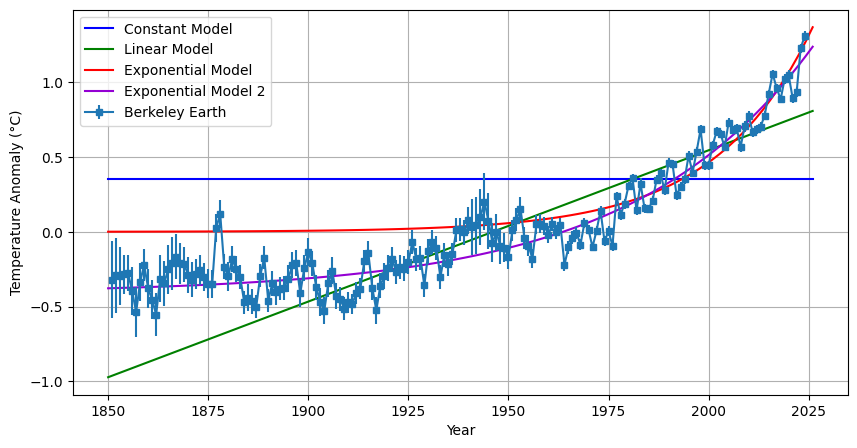

In [13]:
plt.figure(figsize=(10, 5))

# Define x range
x = np.linspace(1850, 2026, 100)  
# Plot the constant function
plt.plot(x, np.full_like(x, k_best), label="Constant Model", color="blue")

# Plot the linear function
plt.plot(x, a_best * (x - 1937) + b_best, label="Linear Model", color="green")

# Plot the exponential function
plt.plot(x, c_best * np.exp(d_best*(x - 1937)) , label="Exponential Model", color="red")
#plt.fill_between(x, c_lower_95 * np.exp(d_lower_95*(x - 1937)), c_upper_95 * np.exp(d_upper_95*(x - 1937)), label = "95% Credible Interval", color = "yellow")

# Plot the exponential 2 function
plt.plot(x, e_best * np.exp(f_best*(x - 1937)) + g_best, label="Exponential Model 2", color="darkviolet")



plt.errorbar( df['Year'], df['Annual_Anomaly'], df['Annual_Anomaly_Error'], label='Berkeley Earth', fmt='s',  markersize= 5, linestyle= "-")
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()

### Model comparison

Our aim is to understand which model predicts better our data $D$. To do so we use the logarithm of Bayes factor $K$, the ratio between the evidences $Z_i$ of the models $M_i$ and $M_j$ we want to compare.

$$
    \frac{Z_i}{Z_j} = \frac{\int d\theta _i P(\theta _i|M_i) P(D|\theta _i,M_i)}{\int d\theta _ j P(\theta _j|M_j) P(D|\theta _j,M_j)} \; ,
$$
where
$$
K = \ln{\left(\frac{Z_i}{Z_j}\right)} = \ln{\left(\frac{e^{\ln{Z_i}}}{e^{\ln{Z_j}}}\right)} = \left(\ln{Z_i} - \ln{Z_j}\right) \; .
$$



In [14]:
exp_result['logz'] - lin_result['logz']

np.float64(630.7391504594227)

In [15]:
#Bayes factor evaluation

#lin/const
K_lin_const =  lin_result['logz'] - const_result['logz'] 
print("K (lin/const) = " , K_lin_const)
print("The linear temperature model is" , K_lin_const,  "times more probable than the constant temperature model")

#exp2/const
K_exp2_const = exp2_result['logz'] - const_result['logz'] 
print("K (exp2/const) = " , K_exp2_const)
print("The exponential temperature model 2 is", K_exp2_const, "times more probable than the constant temperature model assuming the models are equally probable a priori.")


#exp2/exp
K_exp2_lin = exp2_result['logz'] - lin_result['logz'] 
print("K (exp2/lin) = " , K_exp2_lin)
print("The exponential temperature model 2 is", K_exp2_lin, "times more probable than the linear temperature model assuming the models are equally probable a priori.")

#exp2/exp
K_exp2_exp = exp2_result['logz'] - exp_result['logz'] 
print("K (exp2/exp) = " , K_exp2_exp)
print("The exponential temperature model 2 is", K_exp2_exp, "times more probable than the exponential temperature model assuming the models are equally probable a priori.")


K (lin/const) =  5545.653221162291
The linear temperature model is 5545.653221162291 times more probable than the constant temperature model
K (exp2/const) =  6808.863567881017
The exponential temperature model 2 is 6808.863567881017 times more probable than the constant temperature model assuming the models are equally probable a priori.
K (exp2/lin) =  1263.210346718726
The exponential temperature model 2 is 1263.210346718726 times more probable than the linear temperature model assuming the models are equally probable a priori.
K (exp2/exp) =  632.4711962593033
The exponential temperature model 2 is 632.4711962593033 times more probable than the exponential temperature model assuming the models are equally probable a priori.


## Gaussian Process Regression

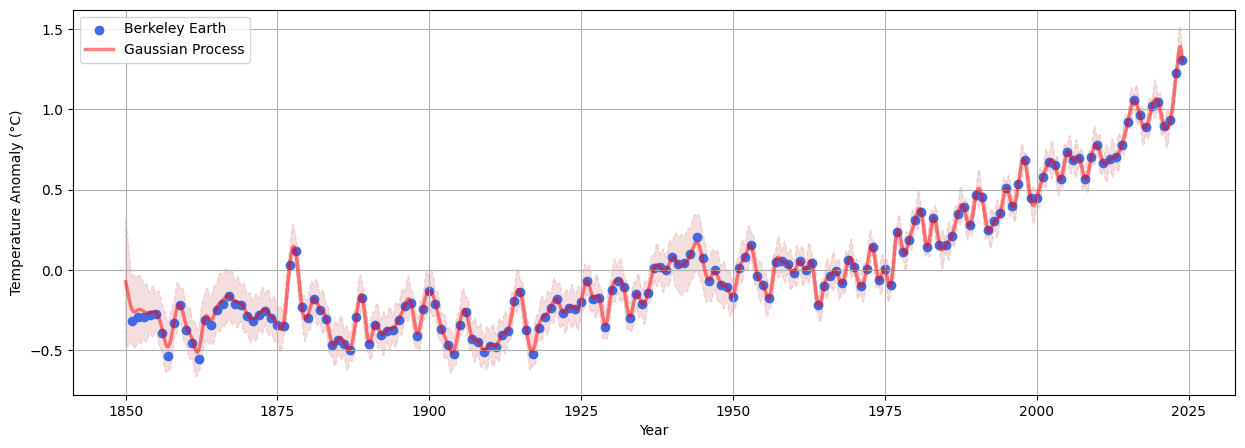

In [16]:
#mean value equal to zero
kernel = np.var(df['Annual_Anomaly']) * george.kernels.ExpSquaredKernel(0.5)   
gp = george.GP(kernel)
gp.compute(df['Year'], df['Annual_Anomaly_Error'])

x_pred = np.linspace(1850, 2024, 1000)
pred, pred_var = gp.predict(df['Annual_Anomaly'], x_pred, return_var = True)


plt.figure(figsize=(15, 5))
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var), color = "indianred", alpha = 0.2, linestyle = "--")

plt.scatter(df['Year'], df['Annual_Anomaly'], color = "royalblue", label='Berkeley Earth', linestyle= "-")
plt.plot(x_pred, pred, color = "red", lw = 2.5, alpha = 0.5, label = 'Gaussian Process')
plt.grid(True)
plt.xlabel('Year')
plt.ylabel('Temperature Anomaly (°C)')
plt.legend()
plt.show()


$$
K_i = \sigma_i^2 e^{-\frac{\left(x\right)^2}{2l_i^2}}
$$

#### Gaussian Model with constant mean:

In [17]:
const_GP_params = ['sigma', 'l', 'k']

def const_GP_loglikelihood(params):
    (sigma, l, k) = params
    
    kernel = sigma ** 2 * george.kernels.ExpSquaredKernel(1/(2 * l ** 2)) 
    gp = george.GP(kernel)
    gp.compute(year, temp_err)

    zero_mean = temp - k
    
    return gp.log_likelihood(zero_mean)

def const_GP_prior(u):
    params = u.copy()
    hi = [1., 20., 1.]
    lo = [0., 0., -1.]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params

In [18]:
const_GP_sampler = ultranest.ReactiveNestedSampler(const_GP_params, const_GP_loglikelihood, const_GP_prior)

In [ ]:
const_GP_result = const_GP_sampler.run(min_num_live_points=1000, viz_callback=None)

[ultranest] Sampling 1000 live points from prior ...


KeyboardInterrupt: 

In [ ]:
const_GP_sampler.print_results()


logZ = 22.616 +- 0.118
  single instance: logZ = 22.616 +- 0.099
  bootstrapped   : logZ = 22.582 +- 0.118
  tail           : logZ = +- 0.010
insert order U test : converged: True correlation: inf iterations

    sigma               : 0.245 │ ▁▁▁▁▁▁▂▄▅▆▇▇▆▆▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁ ▁   ▁ │0.569     0.355 +- 0.030
    l                   : 0.348 │ ▁▁▁▁▁▂▂▃▄▅▇▇▇▆▆▅▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁ ▁ │0.524     0.413 +- 0.021
    k                   : -0.229│ ▁▁▁▁▁▁▁▁▁▂▂▃▄▅▆▆▇▇▇▆▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁ │0.289     0.017 +- 0.057



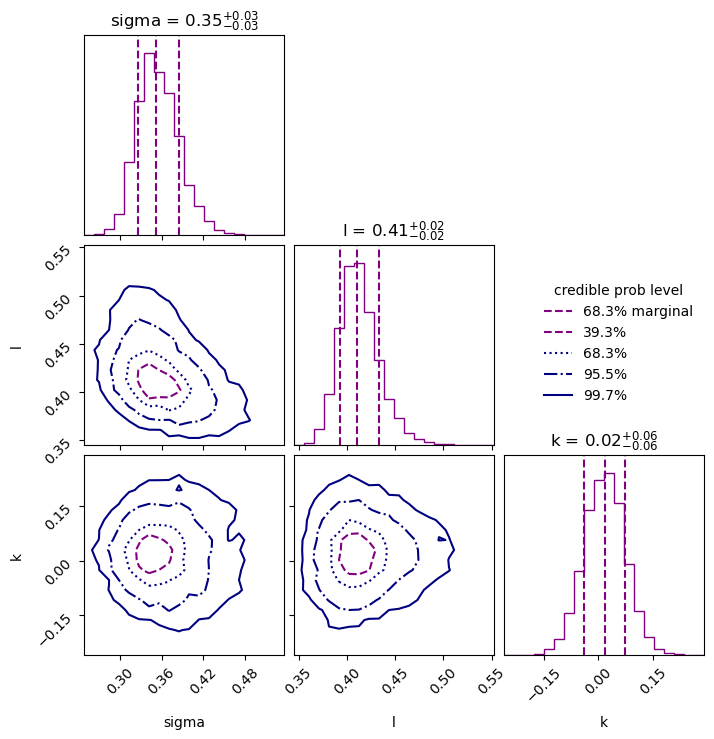

In [ ]:
cornerplot(const_GP_result)

In [ ]:
sigma_samples = const_GP_result["samples"][:, 0] 
sigma_best = np.median(const_GP_samples)
sigma_lower_95, sigma1_upper_95 = np.percentile(const_GP_samples, [2.5, 97.5])

#### Gaussian Proces with linear mean:

In [ ]:
lin_GP_params = ['sigma', 'l', 'a', 'b']

def lin_GP_loglikelihood(params):
    (sigma, l, a, b) = params
    
    kernel = sigma ** 2 * george.kernels.ExpSquaredKernel(1/(2 * l ** 2)) 
    gp = george.GP(kernel)
    gp.compute(year, temp_err)

    zero_mean = temp - (a*(year - 1937) - b)
    
    return gp.log_likelihood(zero_mean)

def lin_GP_prior(u):
    params = u.copy()
    hi = [1., 20., 0.05, 2]
    lo = [0., 0., -0.05, -2]
    for i in range(len(hi)):
        params[i] = lo[i] + (hi[i]-lo[i])*u[i]
    
    return params


In [27]:
lin_GP_sampler = ultranest.ReactiveNestedSampler(lin_GP_params, lin_GP_loglikelihood, lin_GP_prior)
lin_GP_result = lin_GP_sampler.run(min_num_live_points=1000, viz_callback=None)
lin_GP_sampler.print_results()
cornerplot(lin_GP_result)

[ultranest] Sampling 1000 live points from prior ...


KeyboardInterrupt: 